# Лабораторная работа по Spark

### Выполнила Бабушкина Татьяна

In [117]:
!pip install pyspark
!pip install findspark

In [118]:
import pyspark
from pyspark.sql.functions import *
import findspark
findspark.init()

import pyspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import re

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [119]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

findspark.find()

'/opt/spark'

In [120]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


Загрузим данные, посмотрим на них, выведем схему, узнаем сколько всего записей

In [121]:
df = spark.read.json("npl_news.json")
df.show(10)

+---------------+-------------+----------+--------------------+--------------------+--------------------+
|        authors|     category|      date|            headline|                link|   short_description|
+---------------+-------------+----------+--------------------+--------------------+--------------------+
|Melissa Jeltsen|        CRIME|2018-05-26|There Were 2 Mass...|https://www.huffi...|She left her husb...|
|  Andy McDonald|ENTERTAINMENT|2018-05-26|Will Smith Joins ...|https://www.huffi...|Of course it has ...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Hugh Grant Marrie...|https://www.huffi...|The actor and his...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Jim Carrey Blasts...|https://www.huffi...|The actor gives D...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Julianna Margulie...|https://www.huffi...|The "Dietland" ac...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Morgan Freeman 'D...|https://www.huffi...|"It is not right ...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Dona

In [122]:
df.printSchema()

root
 |-- authors: string (nullable = true)
 |-- category: string (nullable = true)
 |-- date: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- link: string (nullable = true)
 |-- short_description: string (nullable = true)



In [123]:
print('Всего новостных записей: %d' % df.count())

Всего новостных записей: 124989


Немного обработаем данные(удалим дубликаты и null-строки)

In [124]:
df \
    .distinct() \
    .show()

+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|             authors|     category|      date|            headline|                link|   short_description|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|          Ron Dicker|       SPORTS|2018-05-23|NFL Bans Kneeling...|https://www.huffi...|Teams can set the...|
|      Matthew Jacobs|ENTERTAINMENT|2018-04-28|All The Movies Th...|https://www.huffi...|Whether you're lo...|
|           Lee Moran|   WEIRD NEWS|2018-04-27|Pets Are 'The 1 P...|https://www.huffi...|The 25 most profo...|
|Sebastian Murdock...|        CRIME|2018-04-24|Dallas Officer Sh...|https://www.huffi...|Officer Rogelio S...|
|  Akbar Shahid Ahmed|     POLITICS|2018-04-18|Top GOP Senator H...|https://www.huffi...|Senate Foreign Re...|
|        Sara Boboltz| BLACK VOICES|2018-04-13|Cal Poly Presiden...|https://www.huffi...|The student said ...|
|

In [125]:
df \
    .distinct() \
    .na.drop("all") \
    .show()

+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|             authors|     category|      date|            headline|                link|   short_description|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|          Ron Dicker|       SPORTS|2018-05-23|NFL Bans Kneeling...|https://www.huffi...|Teams can set the...|
|      Matthew Jacobs|ENTERTAINMENT|2018-04-28|All The Movies Th...|https://www.huffi...|Whether you're lo...|
|           Lee Moran|   WEIRD NEWS|2018-04-27|Pets Are 'The 1 P...|https://www.huffi...|The 25 most profo...|
|Sebastian Murdock...|        CRIME|2018-04-24|Dallas Officer Sh...|https://www.huffi...|Officer Rogelio S...|
|  Akbar Shahid Ahmed|     POLITICS|2018-04-18|Top GOP Senator H...|https://www.huffi...|Senate Foreign Re...|
|        Sara Boboltz| BLACK VOICES|2018-04-13|Cal Poly Presiden...|https://www.huffi...|The student said ...|
|

In [126]:
cluster = 'headline'
cleaner = F.udf(lambda s: re.sub(r'[^a-z ]', '', s), StringType())

df = df \
    .filter(F.length(cluster) > 0) \
    .withColumn(
        cluster, cleaner(F.lower(F.col(cluster)))
    )

Пункт № 1
Считаем какие авторы и сколько раз встречались в общем пуле данных (1 автор - количество повторений)

№ 1.1
Стоит отметить, что часто в графе "author" можно встретить нескольких соавторов, разделенных запятыми или союзами, или с маленькой буквы написаны имена. Это нужно отделить, далее рассматривать только ненулевые значения. 

In [127]:
df1 = df.withColumn("author", explode(split(col("authors"), "\s+|\s+and\s+|\,\s*|\:\s*|\&\s+|\;\s*"))) \
.filter((col("author") != "...") & (col("author") != "") & ~(lower(col('author')).isin(stopwords.words('english'))))\
.groupBy("author") \
.agg(count(col("author")).alias("count"))\
.orderBy(col("count").desc())

In [128]:
df1.show(10, False)

+-----------------+-----+
|author           |count|
+-----------------+-----+
|Reuters          |3424 |
|Lee              |2627 |
|ContributorAuthor|2609 |
|Michael          |2583 |
|Moran            |2447 |
|David            |2246 |
|ContributorWriter|1833 |
|Ron              |1821 |
|Dicker           |1808 |
|writer           |1700 |
+-----------------+-----+
only showing top 10 rows



№ 1.2 Считаем статистику по категориям (сколько новостей в каждой категории)

In [144]:
df2 = df.groupBy(col("category"))\
.agg(count("*").alias("Количество записей"))

In [145]:
df2.show(10, False)

+-------------+------------------+
|category     |Количество записей|
+-------------+------------------+
|SPORTS       |4167              |
|MEDIA        |2814              |
|BLACK VOICES |3858              |
|POLITICS     |32738             |
|ARTS         |1509              |
|THE WORLDPOST|3664              |
|QUEER VOICES |4994              |
|GREEN        |2622              |
|ENTERTAINMENT|14257             |
|TECH         |1231              |
+-------------+------------------+
only showing top 10 rows



№ 1.3 Покажем наиболее часто встречающиеся слова в ['headline']

In [131]:
df3 = df.withColumn("word", explode(split(col("headline"), "\s+"))) \
.filter((col("word") != "") & ~(col('word').isin(stopwords.words('english'))))\
.groupBy(lower(col("word")).alias("word")) \
.agg(count("*").alias("count"))  \
.orderBy(col("count").desc())

In [132]:
df3.show(10, False)

+------+-----+
|word  |count|
+------+-----+
|trump |9550 |
|new   |5555 |
|donald|4573 |
|us    |3330 |
|trumps|3153 |
|says  |3140 |
|women |2215 |
|people|2096 |
|one   |1948 |
|first |1918 |
+------+-----+
only showing top 10 rows



### Построим гистограммы для предыдущих пунктов

№ 2.1

Text(0.5, 0.98, 'Популярность авторов')

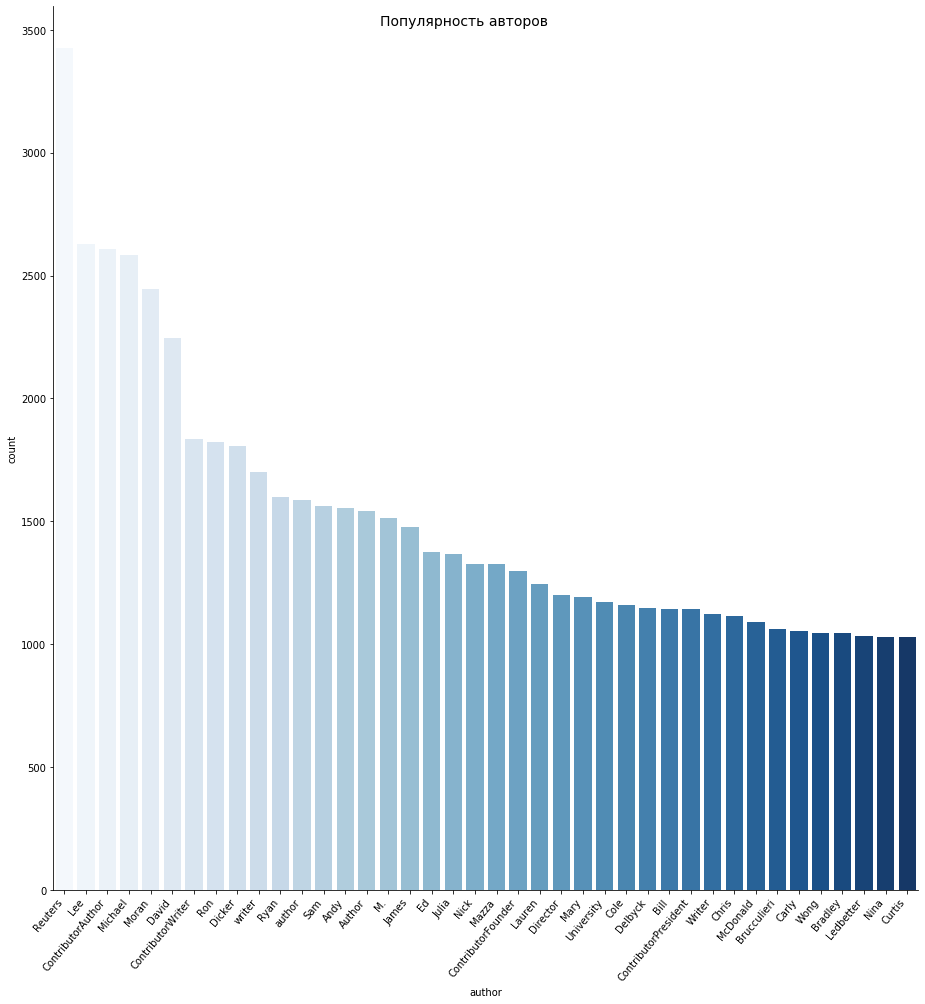

In [133]:
output_pandas_first = df1.toPandas()
chart = sns.catplot(x="author", y="count", kind="bar", data=output_pandas_first[:40], height=13, palette = 'Blues')
chart.set_xticklabels(rotation=50, horizontalalignment='right')
chart.fig.suptitle('Популярность авторов', fontsize=14)

№ 2.2

In [134]:
dff = df.groupBy(col("category")).agg(count("*").alias("Number of news"))

In [135]:
dff_pandas = dff.toPandas()

Text(0.5, 0.98, 'Статистика по категориям')

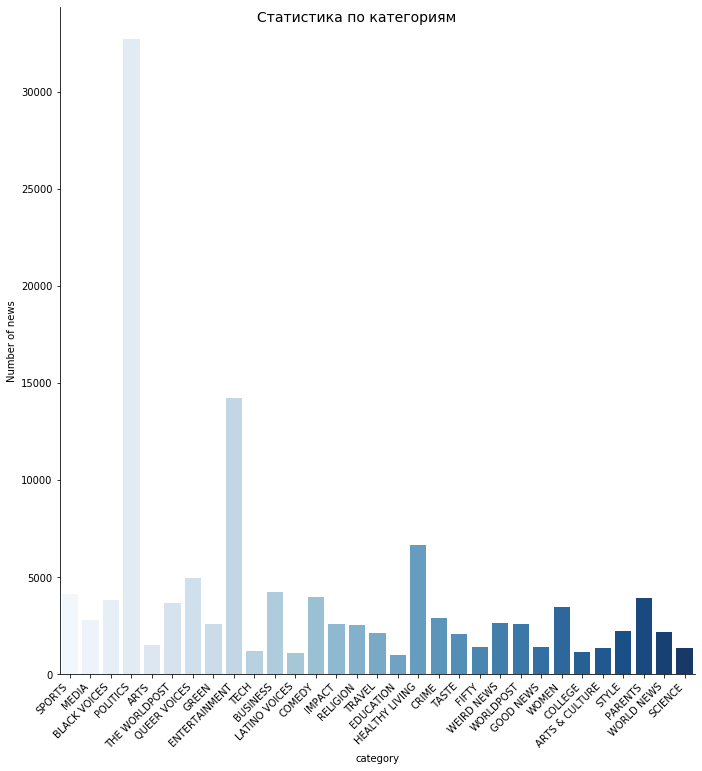

In [136]:
chart = sns.catplot(x="category", y="Number of news", kind="bar", data=dff_pandas, height=10, palette = 'Blues')
chart.set_xticklabels(rotation=45, horizontalalignment='right')
chart.fig.suptitle('Статистика по категориям', fontsize=14)

№ 2.3

In [137]:
df3_pandas = df3.toPandas()

Text(0.5, 0.98, 'Популярность слов')

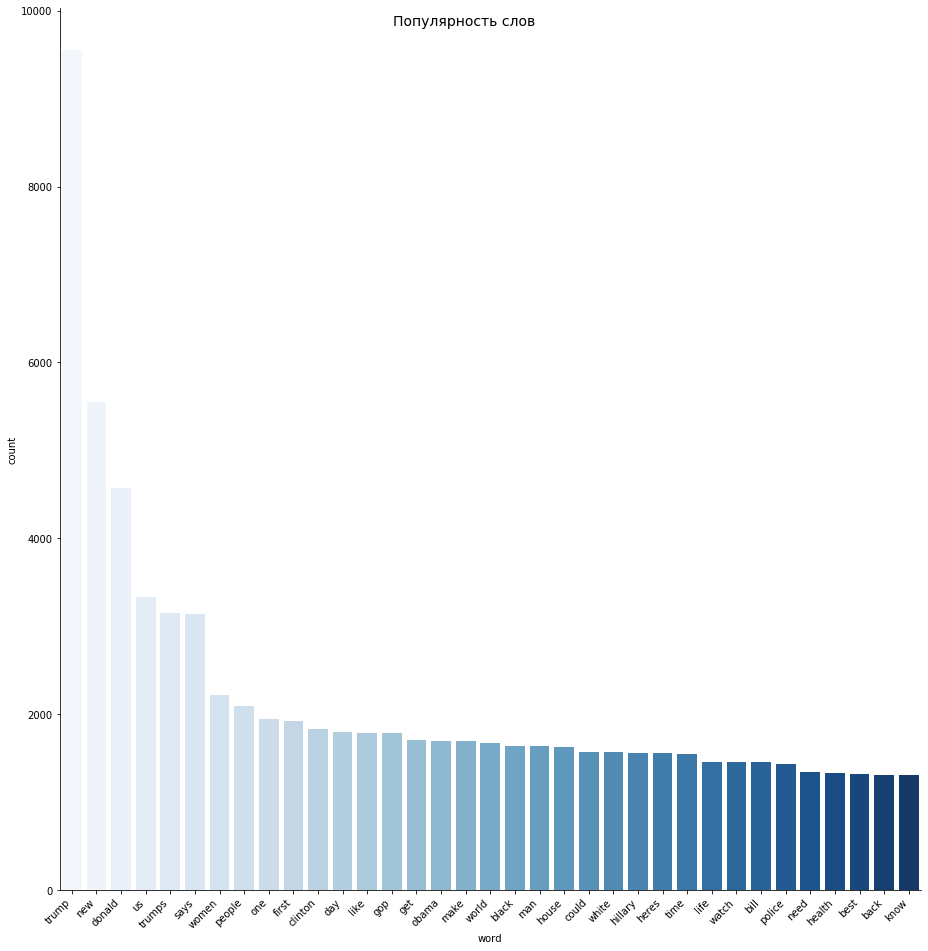

In [138]:
chart = sns.catplot(x="word", y="count", kind="bar", data=df3_pandas[:35], height=13, palette = 'Blues')
chart.set_xticklabels(rotation=45, horizontalalignment='right')
chart.fig.suptitle('Популярность слов', fontsize=14)

№ 3 В какой год было больше новостей про Россию?

Чтобы определить относится ли новость к России, будем смотреть на встречаемость в них(как в заголовке, так и в описании) слов, описывающих Россию. Делаю акцент на словах: russia, russian federation, moscow,  petersburg, putin, navalny, kremlin. Если в статье есть хотя бы одно это слово, то считаем, что статья относится к России. Чем больше статей с этими словами, тем больше упоминаний России в СМИ. Теперь группируем по годам и рисуем гистограмму.

In [139]:
russiandf = df.withColumn("tmp", split("date", "\\-"))\
.withColumn("year", col("tmp").getItem(0))\
.filter(((lower(col('headline')).contains('russia')) | (lower(col('headline')).contains('russian federation')) | (lower(col('headline')).contains('moscow')) | (lower(col('headline')).contains('petersburg')) | (lower(col('headline')).contains('putin')) | (lower(col('headline')).contains('navalny')) | (lower(col('headline')).contains('kremlin'))) | (lower(col('link')).contains('russia')) | (lower(col('link')).contains('russian federation')) | (lower(col('link')).contains('moscow'))  | (lower(col('link')).contains('petersburg')) | (lower(col('link')).contains('putin'))  | (lower(col('link')).contains('navalny')) | (lower(col('link')).contains('kremlin')) | (lower(col('short_description')).contains('russia')) |  (lower(col('short_description')).contains('russian federation')) | (lower(col('short_description')).contains('moscow')) | (lower(col('short_description')).contains('petersburg')) | (lower(col('short_description')).contains('putin'))  | (lower(col('short_description')).contains('navalny')) | (lower(col('short_description')).contains('kremlin')))\
.groupBy("year")\
.agg(count("*").alias("Количество упоминаний России"))\
.select(col("year"), col("Количество упоминаний России"))\
.orderBy(col("Количество упоминаний России").desc())

In [140]:
russiandf.show(10, False)

+----+----------------------------+
|year|Количество упоминаний России|
+----+----------------------------+
|2017|863                         |
|2016|405                         |
|2018|242                         |
|2014|170                         |
|2015|161                         |
+----+----------------------------+



In [141]:
russian_panda = russiandf.toPandas()

Text(0.5, 0.98, 'Количество упоминаний России с 2014 по 2018 годы')

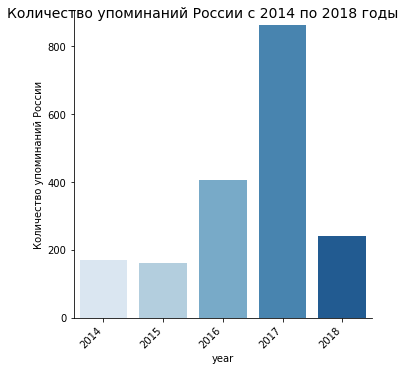

In [142]:
chart = sns.catplot(x="year", y="Количество упоминаний России", kind="bar", data=russian_panda, height=5, palette = 'Blues')
chart.set_xticklabels(rotation=45, horizontalalignment='right')
chart.fig.suptitle('Количество упоминаний России с 2014 по 2018 годы', fontsize=14)